<a href="https://colab.research.google.com/github/UwailaEkhator/Accented-English-Speech-Recognition-and-Transcription/blob/main/Finetuning_Whisper_on_Indian_Accents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP PROJECT
- Sharadha
- Tapiwa
- Uwaila

## Finetuning Whisper using more Indian accents
We want to finetune Whisper using more data of people with Indian accents to see if it improves Whispers performance and reduces the WER on Indian accents

In [ ]:
#Prepare environment
#!pip install --upgrade pip
#!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio


In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
#Load dataset for finetuning
import pandas as pd
hindi_traindata = pd.read_csv('/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning/cv-valid-train.csv')
hindi_traindata

,filename,text,gender,accent
0,cv-valid-train/sample-000029.mp3,the fire alarm went off again but when i looke...,male,indian
1,cv-valid-train/sample-000068.mp3,the flock of flamingos landed gracefully on th...,male,indian
2,cv-valid-train/sample-000092.mp3,who is this stranger who speaks of omens asked...,male,indian
3,cv-valid-train/sample-000167.mp3,the boy waited and then interrupted the old ma...,male,indian
4,cv-valid-train/sample-000214.mp3,he said to float away to happy land on the bub...,female,indian
...,...,...,...,...
4485,cv-valid-train/sample-195508.mp3,you look at me as if you didn't know me,female,indian
4486,cv-valid-train/sample-195537.mp3,to cut to the chase the harvest was really bad,female,indian
4487,cv-valid-train/sample-195654.mp3,the old man returned the book to the boy,male,indian
4488,cv-valid-train/sample-195673.mp3,we're a couple of financial wizards,female,indian


In [ ]:
_#drop unneccessary columns
hindi_traindata.drop(columns = ['gender', 'accent'], inplace=True)

In [ ]:
#removing cv-valid-train/ from 'hindi_testdata' dataframe
hindi_traindata['filename']=hindi_traindata['filename'].str.replace('cv-valid-train/', '')

In [ ]:
hindi_traindata

,filename,text
0,sample-000029.mp3,the fire alarm went off again but when i looke...
1,sample-000068.mp3,the flock of flamingos landed gracefully on th...
2,sample-000092.mp3,who is this stranger who speaks of omens asked...
3,sample-000167.mp3,the boy waited and then interrupted the old ma...
4,sample-000214.mp3,he said to float away to happy land on the bub...
...,...,...
4485,sample-195508.mp3,you look at me as if you didn't know me
4486,sample-195537.mp3,to cut to the chase the harvest was really bad
4487,sample-195654.mp3,the old man returned the book to the boy
4488,sample-195673.mp3,we're a couple of financial wizards


In [ ]:
#Prepare Feature Extractor, Tokenizer and Data

#Load WhisperFeatureExtractor
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny.en")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
#Load WhisperTokenizer
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

In [ ]:
#Testing the tokenizer
input_str = hindi_traindata["text"][0]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")


Input:                 the fire alarm went off again but when i looked outside there was no one there
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|>the fire alarm went off again but when i looked outside there was no one there<|endoftext|>
Decoded w/out special: the fire alarm went off again but when i looked outside there was no one there
Are equal:             True


In [ ]:
#combining the feature extractor and tokenizer to create a WhisperProcessor
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")


In [ ]:
!pip install datasets
from datasets import Dataset, Audio, load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
#Prepare training data

#audio files directory
audio_directory = '/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning/train_audio'

#add path to audio files
hindi_traindata['audio'] = hindi_traindata['filename'].apply(lambda x: f"{audio_directory}/{x}")

#convert dataframe to datasets dataset
hindi_traindata = Dataset.from_pandas(hindi_traindata)

In [ ]:
hindi_traindata

Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 4490
})

In [ ]:
# Cast the audio column to Audio feature with a sampling rate of 16,000 Hz
hindi_traindata2 = hindi_traindata.cast_column("audio", Audio(sampling_rate=16000))
hindi_traindata2


Dataset({
    features: ['filename', 'text', 'audio'],
    num_rows: 4490
})

In [ ]:
#hindi_traindata2['audio'][0]

In [ ]:


def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text"]).input_ids
    return batch

In [ ]:



hindi_traindata2 = hindi_traindata2.map(prepare_dataset, remove_columns=hindi_traindata2.column_names, num_proc=1)


Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

In [ ]:
hindi_traindata2

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 4490
})

In [ ]:
#preparing test data
hindi_testdata = pd.read_csv('/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning/cv-valid-test.csv')

#drop unneccessary columns
hindi_testdata.drop(columns = ['gender', 'accent'], inplace=True)

#removing cv-valid-train/ from 'hindi_testdata' dataframe
hindi_testdata['filename']=hindi_testdata['filename'].str.replace('cv-valid-test/', '')

#audio files directory
audio_directory2 = '/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning/test_audio'

#add path to audio files
hindi_testdata['audio'] = hindi_testdata['filename'].apply(lambda x: f"{audio_directory2}/{x}")

#convert dataframe to datasets dataset
hindi_testdata2 = Dataset.from_pandas(hindi_testdata)

# Cast the audio column to Audio feature with a sampling rate of 16,000 Hz
hindi_testdata2= hindi_testdata2.cast_column("audio", Audio(sampling_rate=16000))


hindi_testdata2 = hindi_testdata2.map(prepare_dataset, remove_columns=hindi_testdata2.column_names, num_proc=1)


Map:   0%|          | 0/91 [00:00<?, ? examples/s]

In [ ]:
#Training and Evaluation

#Define a Data Collator
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [ ]:
#initializing the data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


In [ ]:
#!pip install evaluate
#!pip install jiwer

In [ ]:
#Evaluation metrics
!pip install evaluate jiwer
import evaluate

metric = evaluate.load("wer")

#a function that takes our models predictions and returns the WER
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}



In [ ]:
#Loading the pretrained whisper tiny that we used earlier
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

In [ ]:
#model.generation_config


In [ ]:
# ##attempt to reduce WER****

# # Extract input features from the dataset
# train_input_features = hindi_traindata2['input_features']
# test_input_features = hindi_testdata2['input_features']

# # Generate text using the input features
# train_generated_text = model.generate(input_features=train_input_features, temperature=0)
# test_generated_text = model.generate(input_features=test_input_features, temperature=0)


In [ ]:
# from transformers import Seq2SeqTrainer
# import torch

# # Define a function to generate text during training
# def generate_during_training(model, input_features, tokenizer):
#     model.eval()
#     with torch.no_grad():
#         generated_text = model.generate(input_features=input_features, temperature=0)
#     model.train()
#     return tokenizer.batch_decode(generated_text, skip_special_tokens=True)

# # Define your custom training loop
# def custom_training_loop(model, trainer, train_dataset, test_dataset, data_collator, tokenizer, num_epochs, generation_interval):
#     for epoch in range(num_epochs):
#         # Train the model
#         trainer.train()

#         # Generate text during training for evaluation
#         if epoch % generation_interval == 0:
#             # Generate text for training dataset
#             train_input_features = train_dataset['input_features']
#             train_generated_text = generate_during_training(model, train_input_features, tokenizer)
#             print(f'Training Text Generation at Epoch {epoch}:')
#             print(train_generated_text)

#             # Generate text for test dataset
#             test_input_features = test_dataset['input_features']
#             test_generated_text = generate_during_training(model, test_input_features, tokenizer)
#             print(f'Test Text Generation at Epoch {epoch}:')
#             print(test_generated_text)

# # Set up the trainer
# trainer = Seq2SeqTrainer(
#     args=training_args,
#     model=model,
#     train_dataset=hindi_traindata2,
#     eval_dataset=hindi_testdata2,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
#     tokenizer=processor.feature_extractor
# )

# # Run the custom training loop
# custom_training_loop(model, trainer, hindi_traindata2, hindi_testdata2, data_collator, processor.feature_extractor, num_epochs=3, generation_interval=1)


In [ ]:
#setting the language and task argument
#model.generation_config.language = "english"
#model.generation_config.task = "transcribe"

#model.generation_config.forced_decoder_ids = None


In [ ]:
!pip uninstall accelerate transformers

Found existing installation: transformers 4.38.2
Uninstalling transformers-4.38.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.38.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.38.2


In [ ]:
!pip install accelerate>=0.20.3 transformers

In [ ]:
#Define training arguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=2e-5,
    warmup_steps=50,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=6,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)


In [ ]:
#forwarding the training arguments, dataset, data collator and compute_metrics to our Trainer
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=hindi_traindata2 ,
    eval_dataset=hindi_testdata2,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    #condition_on_previous_text=True
    #feature_extractor=processor.feature_extractor
)



TypeError: Seq2SeqTrainer.__init__() got an unexpected keyword argument 'condition_on_previous_text'

In [ ]:
#Training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
10,4.786400,4.723161,40.625000
20,4.104400,3.421076,35.875000
30,2.879500,2.333836,28.125000
40,2.093000,1.882533,22.250000
50,1.772000,1.614157,18.125000
60,1.511400,1.402413,41.750000
70,1.322600,1.197526,156.625000
80,1.150700,0.968634,192.375000
90,0.891800,0.766581,13.375000
100,0.735100,0.595090,12.375000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 357, 366, 438, 532, 685, 705, 796, 930, 1058, 1220, 1267, 1279, 1303, 1343, 1377, 1391, 1635, 1782, 1875, 2162, 2361, 2488, 3467, 4008, 4211, 4600, 4808, 5299, 5855, 6329, 7203, 9609, 9959, 10563, 10786, 11420, 11709, 11907, 13163, 13697, 13700, 14808, 15306, 16410, 16791, 17992, 19203, 19510, 20724, 22305, 22935, 27007, 30109, 30420, 33409, 34949, 40283, 40493, 40549, 47282, 49146, 50257, 50357, 50358, 50359, 50360, 50361], 'begin_suppress_tokens': [220, 50256]}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarnin

TrainOutput(global_step=500, training_loss=0.5719401693344116, metrics={'train_runtime': 3111.971, 'train_samples_per_second': 2.571, 'train_steps_per_second': 0.161, 'total_flos': 1.9680336764928e+17, 'train_loss': 0.5719401693344116, 'epoch': 1.7793594306049823})

In [ ]:
#import transformers

In [ ]:
#!pip install sentence-transformers==2.3.1
#!pip install transformers==4.37.2

In [ ]:
from transformers import pipeline

# Define the path to the trained model directory
model_path = "/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning/checkpoint-270"

# Load the tokenizer
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")


whisper_pipe = pipeline("automatic-speech-recognition",
    model=model_path,
    tokenizer=tokenizer)

# Perform inference using the pipeline
audio_file_path = "/content/drive/Shareddrives/NLP Shared/NLP Project/india_rec/hindi1.mp3"  # Specify the path to the audio file you want to transcribe
transcription_ft = whisper_pipe(audio_file_path)

# Print the transcription


In [ ]:
transcription_ft['text']

'please call stellar ask her to bring these things with her from the store six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack of snack for her brother bob we also need a small plastic snake and a big toy frog for the kids she can scoop these things into three red bags and we will go meet her wednesday at the train station'

In [ ]:
!pip install librosa
import librosa

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

In [ ]:
filename = '/content/drive/Shareddrives/NLP Shared/NLP Project/india_rec/hindi1.mp3'
audio, sr = librosa.load(filename, sr=16000)

waveform = audio
sampling_rate = sr

# Load the Whisper model in Hugging Face format:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

# Use the model and processor to transcribe the audio:
input_features = processor(
    waveform, sampling_rate=sampling_rate, return_tensors="pt"
).input_features

# Generate token ids
predicted_ids = model.generate(input_features)

# Decode token ids to text
transcription_og = processor.batch_decode(predicted_ids, skip_special_tokens=True)

transcription_og[0]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

' Please call Stella, ask her to bring these things with her from the store. 6 spoons of fresh snow peas, 5 thick slabs of blue cheese and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into 3 red bags and we will go meet her Wednesday at the train station.'

In [ ]:
reference_text = 'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.'

In [ ]:
!pip install evaluate
from evaluate import load
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.5 MB/s eta 0:00:00


In [ ]:
from evaluate import load
wer = load("wer")
wer_score = wer.compute(predictions=[transcription_ft['text']], references=[reference_text])

In [ ]:
wer_score

0.2318840579710145

In [ ]:
wer_score = wer.compute(predictions=[transcription_og[0]], references=[reference_text])
wer_score

0.11594202898550725

## Applying original whisper to the indian country accents from initial kaggle dataset and measuring WER

In [ ]:
import os
import librosa

In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

In [ ]:
# Load the Whisper model in Hugging Face format:
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

In [ ]:
import os

In [ ]:
# Path to the directory containing audio files
input_folder = '/content/drive/Shareddrives/NLP Shared/NLP Project/india_rec'

# Check if the directory exists
if not os.path.isdir(input_folder):
    print(f"The directory '{input_folder}' does not exist.")
    exit()

# List all audio files in the directory
audio_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.mp3')])

# Check if any audio files are found
if not audio_files:
    print(f"No audio files found in '{input_folder}'.")
    exit()

# Load the Whisper model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

# List to store transcriptions
transcriptions = {}

# Process each audio file in the list
for audio_file in audio_files:
    audio_path = os.path.join(input_folder, audio_file)

    # Load the audio file and resample to 16000 Hz
    audio, sr = librosa.load(audio_path, sr=16000)

    # Use the model and processor to transcribe the audio
    input_features = processor(audio, sampling_rate=sr, return_tensors="pt").input_features
    predicted_ids = model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Append transcription to the list
    transcriptions[audio_file] = transcription


In [ ]:
import csv

In [ ]:
# Path to the output CSV file
output_csv = 'original_whisper_indian.csv'

# Write transcriptions to CSV
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'Transcription'])

    for key, value in transcriptions.items():
        writer.writerow([key, value])

## Applying Finetuned whisper to the phlippines country accents from initial kaggle dataset and measuring WER

In [ ]:
from transformers import pipeline
import os
import librosa

# Path to the trained model directory
model_path = "/content/drive/Shareddrives/NLP Shared/NLP Project/hindi_data_for_finetuning/checkpoint-270"

# Load the tokenizer and model using the pipeline
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-tiny.en", language="English", task="transcribe")
whisper_pipe = pipeline("automatic-speech-recognition",
    model=model_path,
    tokenizer=tokenizer)

# Path to the directory containing audio files
input_folder = '/content/drive/Shareddrives/NLP Shared/NLP Project/india_rec'

# Check if the directory exists
if not os.path.isdir(input_folder):
    print(f"The directory '{input_folder}' does not exist.")
    exit()

# List all audio files in the directory
audio_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.mp3')])

# Check if any audio files are found
if not audio_files:
    print(f"No audio files found in '{input_folder}'.")
    exit()

# Dictionary to store transcriptions
transcriptions = {}

# Process each audio file in the list
for audio_file in audio_files:
    audio_path = os.path.join(input_folder, audio_file)

    # Perform inference using the pipeline
    transcription = whisper_pipe(audio_path)

    # Store the transcription
    transcriptions[audio_file] = transcription['text']



In [ ]:
# Path to the output CSV file
output_csv = 'finetuned_whisper_indian.csv'

# Write transcriptions to CSV
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'Transcription'])

    for key, value in transcriptions.items():
        writer.writerow([key, value])

We extracted both csv file and merged with the initial csv file that has more columns. see below the new dataframe:

In [ ]:
import pandas as pd

In [ ]:
new_indian_df = pd.read_csv('/content/drive/Shareddrives/NLP Shared/NLP Project/new_custom_india_data.csv')
new_indian_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,Original_Whisper,Finetuned_Whisper
0,34,3.5,"durgapur, west bengal, india",bengali11,bengali,male,1018,india,"Please call Stella, ask her to bring these th...",please call Stella ask her to bring these thin...
1,26,4.0,"kolkata, india",bengali14,bengali,male,1973,india,Please call Stella. Ask her to bring these th...,please call stellar ask her to bring these thi...
2,29,4.0,"jamshedpur, jharkhand, india",bengali6,bengali,male,624,india,"Please call Stella, ask her to bring these th...",please call stellar ask her to bring these thi...
3,61,12.0,"kolkata, india",bengali9,bengali,female,987,india,"Please call Stela, ask her to bring these thi...",please call stella ask her to bring these thi...
4,21,0.0,"bombay, india",english111,english,male,426,india,"Please call Stella, ask her to bring these th...",please call stella ask her to bring these thin...


In [ ]:
#storing the reference text
reference_text = 'please call stella ask her to bring these things with her from the store six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother bob we also need a small plastic snake and a big toy frog for the kids she can scoop these things into three red bags and we will go meet her wednesday at the train station'

In [ ]:
import pandas as pd
import string

# Assuming your dataframe is already loaded and named new_indian_df
# Assuming the column name is 'Original_Whisper'

# Define a function to remove punctuation and convert to lowercase
def normalize_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the function to the column
new_indian_df['Original_Whisper'] = new_indian_df['Original_Whisper'].apply(normalize_text)
new_indian_df['Finetuned_Whisper'] = new_indian_df['Finetuned_Whisper'].apply(normalize_text)
new_indian_df

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,Original_Whisper,Finetuned_Whisper
0,34,3.5,"durgapur, west bengal, india",bengali11,bengali,male,1018,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
1,26,4.0,"kolkata, india",bengali14,bengali,male,1973,india,please call stella ask her to bring these thi...,please call stellar ask her to bring these thi...
2,29,4.0,"jamshedpur, jharkhand, india",bengali6,bengali,male,624,india,please call stella ask her to bring these thi...,please call stellar ask her to bring these thi...
3,61,12.0,"kolkata, india",bengali9,bengali,female,987,india,please call stela ask her to bring these thin...,please call stella ask her to bring these thi...
4,21,0.0,"bombay, india",english111,english,male,426,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
5,28,0.0,"yole, india",english37,english,female,96,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
6,22,0.0,"pondicherry, india",english370,english,male,1302,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...
7,20,15.0,"ahmedabad, india",gujarati1,gujarati,male,198,india,please call stella ask her to bring these thi...,onceonceonceaonceaonceaaa and well go meet her...
8,22,8.0,"bombay, india",gujarati2,gujarati,male,199,india,please call stella ask her to bring these thi...,please call stellar ask her to bring these th...
9,53,16.0,"ahmedabad, india",gujarati4,gujarati,female,610,india,please call stila ask her to bring these thin...,asked her to bring these things with her from...


Applying WER:

In [ ]:
!pip install evaluate
from evaluate import load
!pip install jiwer
wer = load("wer")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.1 MB/s eta 0:00:00


In [ ]:
# Create an empty list to store the WER scores
wer_scores_or = []

# Iterate over each item in the 'original_whisper_transcriptions' column
for transcription in new_indian_df['Original_Whisper']:
    # Compute the WER score
    wer_score = wer.compute(predictions=[transcription], references=[reference_text])
    # Append the WER score to the list
    wer_scores_or.append(wer_score)

# Add the list of WER scores as a new column to the dataframe
new_indian_df['WER_Original'] = wer_scores_or

In [ ]:
# Create an empty list to store the WER scores
wer_scores_ft = []

# Iterate over each item in the 'finetuned_whisper_transcriptions' column
for transcription in new_indian_df['Finetuned_Whisper']:
    # Compute the WER score
    wer_score = wer.compute(predictions=[transcription], references=[reference_text])
    # Append the WER score to the list
    wer_scores_ft.append(wer_score)

# Add the list of WER scores as a new column to the dataframe
new_indian_df['WER_Finetuned'] = wer_scores_ft

In [ ]:
new_indian_df

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,Original_Whisper,Finetuned_Whisper,WER_Original,WER_Finetuned
0,34,3.5,"durgapur, west bengal, india",bengali11,bengali,male,1018,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.057971,0.014493
1,26,4.0,"kolkata, india",bengali14,bengali,male,1973,india,please call stella ask her to bring these thi...,please call stellar ask her to bring these thi...,0.159420,0.086957
2,29,4.0,"jamshedpur, jharkhand, india",bengali6,bengali,male,624,india,please call stella ask her to bring these thi...,please call stellar ask her to bring these thi...,0.014493,0.043478
3,61,12.0,"kolkata, india",bengali9,bengali,female,987,india,please call stela ask her to bring these thin...,please call stella ask her to bring these thi...,0.159420,0.057971
4,21,0.0,"bombay, india",english111,english,male,426,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.101449,0.072464
5,28,0.0,"yole, india",english37,english,female,96,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.057971,0.057971
6,22,0.0,"pondicherry, india",english370,english,male,1302,india,please call stella ask her to bring these thi...,please call stella ask her to bring these thin...,0.014493,0.028986
7,20,15.0,"ahmedabad, india",gujarati1,gujarati,male,198,india,please call stella ask her to bring these thi...,onceonceonceaonceaonceaaa and well go meet her...,0.333333,0.913043
8,22,8.0,"bombay, india",gujarati2,gujarati,male,199,india,please call stella ask her to bring these thi...,please call stellar ask her to bring these th...,0.057971,0.101449
9,53,16.0,"ahmedabad, india",gujarati4,gujarati,female,610,india,please call stila ask her to bring these thin...,asked her to bring these things with her from...,0.420290,0.623188


In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

<ipython-input-13-61b4ff63fb8a>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=new_indian_df, x="country", y="WER_Original", hue="sex", ax=ax,


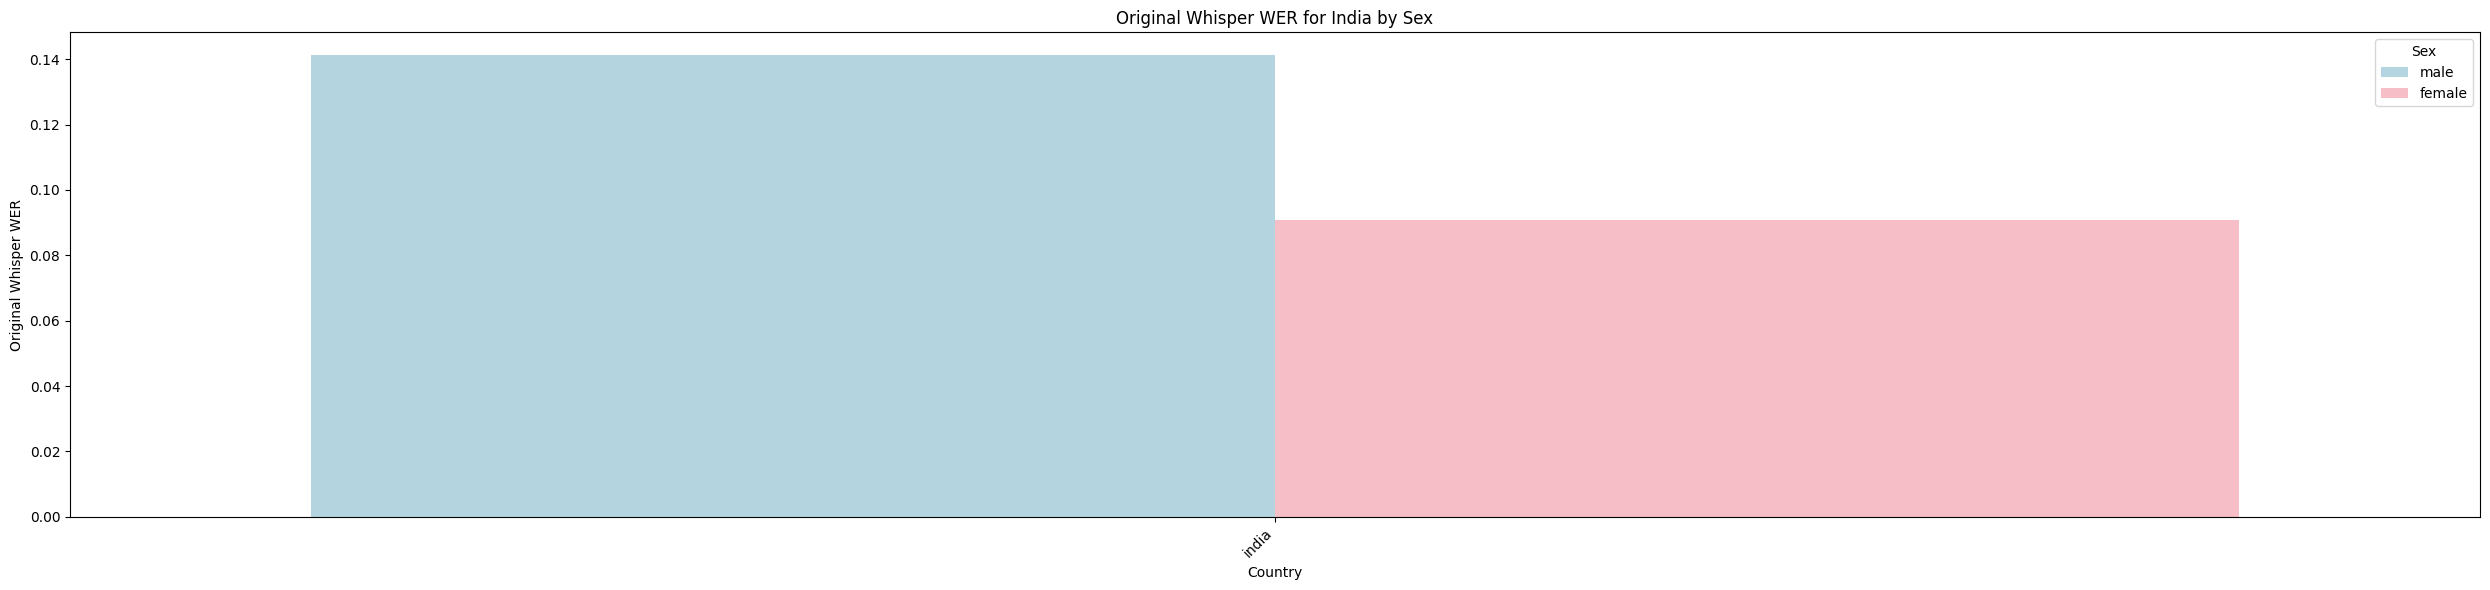

In [ ]:
#Plotting by sex

# Grouped bar plot
f = plt.figure(figsize=(25, 6))
ax = f.add_subplot(1, 1, 1)
color_palette = {"male": "lightblue", "female": "lightpink"}

# Plot
sns.barplot(data=new_indian_df, x="country", y="WER_Original", hue="sex", ax=ax,
            palette=color_palette, ci=None)

# Customizing the plot
ax.set_title("Original Whisper WER for India by Sex")
ax.set_xlabel("Country")
ax.set_ylabel("Original Whisper WER")
ax.legend(title="Sex", loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

<ipython-input-14-00beefaf8612>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=new_indian_df, x="country", y="WER_Finetuned", hue="sex", ax=ax,


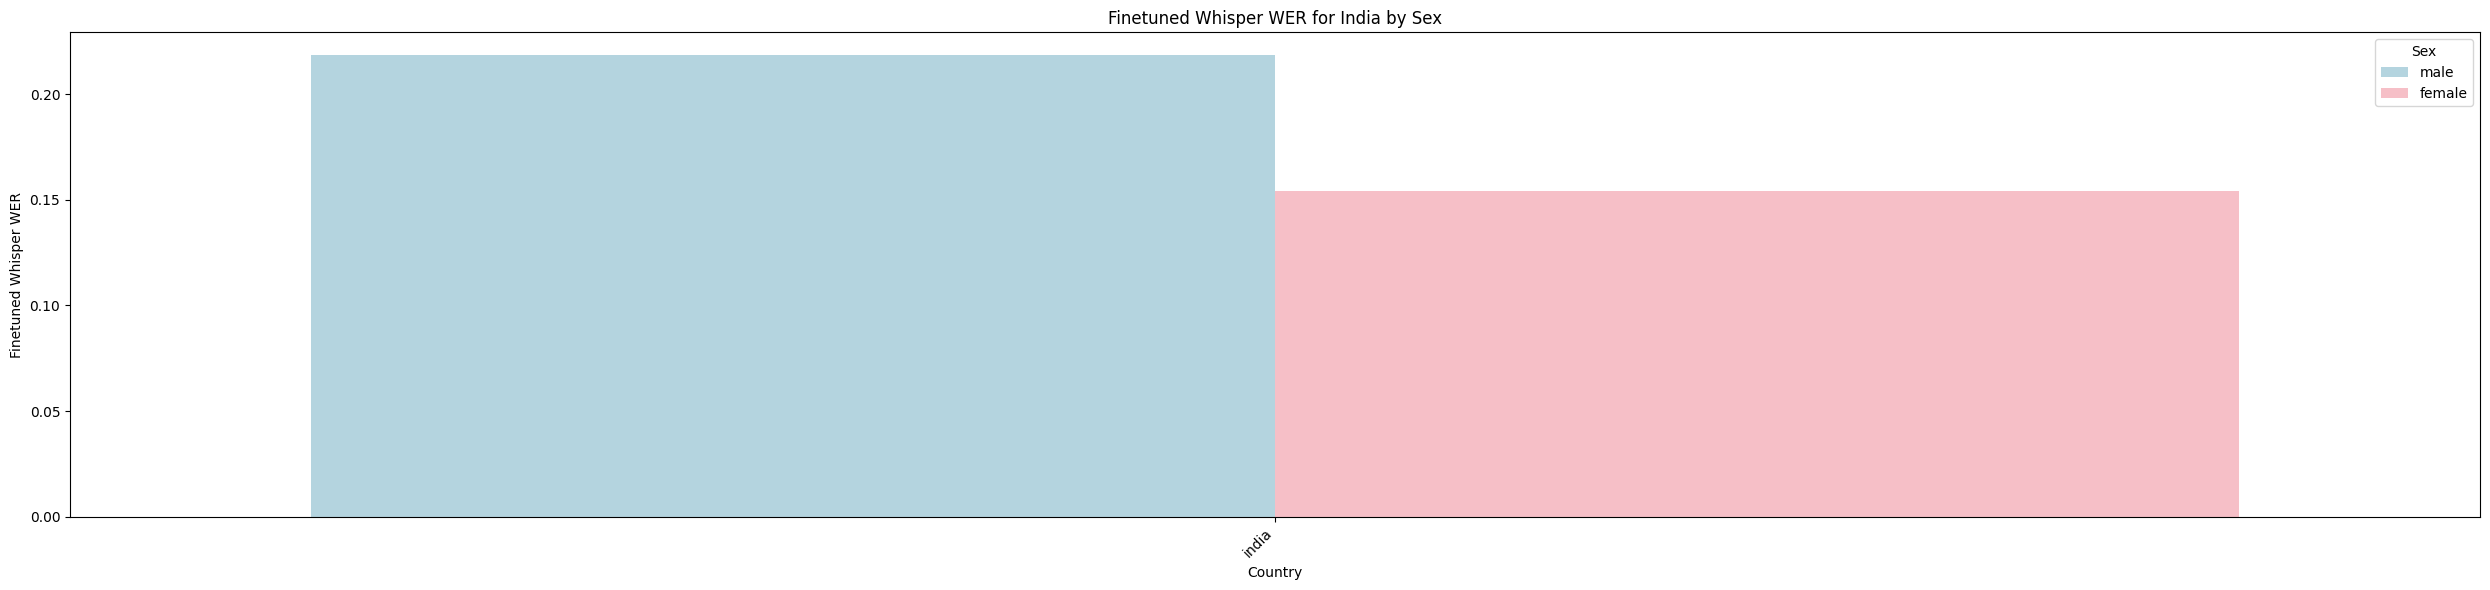

In [ ]:
#Plotting by sex

# Grouped bar plot
f = plt.figure(figsize=(25, 6))
ax = f.add_subplot(1, 1, 1)
color_palette = {"male": "lightblue", "female": "lightpink"}

# Plot
sns.barplot(data=new_indian_df, x="country", y="WER_Finetuned", hue="sex", ax=ax,
            palette=color_palette, ci=None)

# Customizing the plot
ax.set_title("Finetuned Whisper WER for India by Sex")
ax.set_xlabel("Country")
ax.set_ylabel("Finetuned Whisper WER")
ax.legend(title="Sex", loc="upper right")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

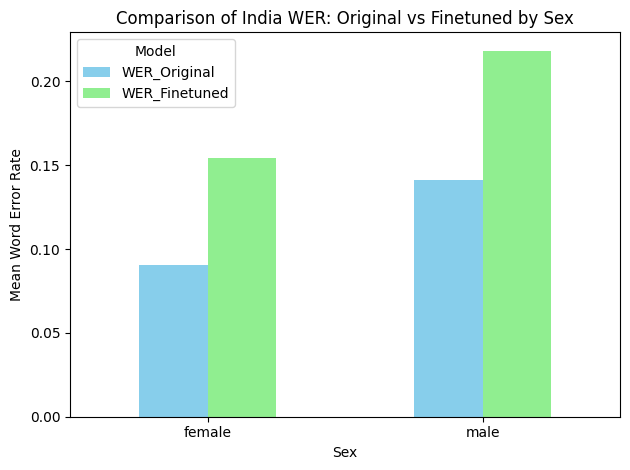

In [ ]:
# Calculating mean WER by sex
mean_wer = new_indian_df.groupby('sex')[['WER_Original', 'WER_Finetuned']].mean()

# Plotting
mean_wer.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Comparison of India WER: Original vs Finetuned by Sex')
plt.xlabel('Sex')
plt.ylabel('Mean Word Error Rate')
plt.xticks(rotation=0)  # Rotates labels to be horizontal
plt.legend(title='Model')
plt.tight_layout()

# Show plot
plt.show()